<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Project <br>
<font color=696880 size=4>
    Project Team 
    
    
____


### Full Name : Nima Alizadeh
### Student Number : 98100504
___

# Introduction

In this project, we are going to have a brief and elementary hands-on real-world project, predicting breast cancer survival using machine learning models with clinical data and gene expression profiles.

# Data Documentation

For this purpose, we will use "Breast Cancer Gene Expression Profiles (METABRIC)" data. 
The first 31 columns of data contain clinical information including death status.
The next columns of the data contain gene's related information which includes both gene expressions and mutation information. (gene's mutation info columns have been marked with "_mut" at the end of the names of the columns) 
For more information please read the [data documentation](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric).

# Data Preparation (15 Points)

In this section you must first split data into three datasets:
<br>
1- clinical dataset
<br>
2- gene expressions dataset
<br>
3- gene mutation dataset. (We will not use this dataset in further steps of the project)

Importing requared libraries:

In [1]:
import pandas as pd
import numpy as np


## Data Loading & Splitting

In [2]:
# TODO
df = pd.read_csv('/content/METABRIC_RNA_Mutation.csv')
print("Shape of initial datase:",df.shape)

# we keep a copy of the initial dataset for furthur analysis
initial_df=df.copy()

Shape of initial datase: (1904, 693)


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (678,688,690,692) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Before splitting the data, we 

In [3]:
# removing rows with unknown data
df.dropna(inplace=True)

# getting labels
labels=df.loc[:,'overall_survival'].to_numpy()

# dropping useless columns
useless_columns=['patient_id','overall_survival','death_from_cancer','cancer_type','er_status_measured_by_ihc','her2_status_measured_by_snp6']
df.drop(columns=useless_columns,inplace=True)

# encoding string elements to integers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
columns_to_encode = []
for i in range(31):
    if(df.iloc[0:5,i].dtype=='object'):
        columns_to_encode.append(df.columns[i])
for column_to_encode in columns_to_encode:
    encoder.fit(np.array(df[column_to_encode]))
    df[column_to_encode]=encoder.transform(df[column_to_encode])
print(df.shape)


(1092, 687)


Now we split the dataframe into three datasets:

In [4]:
clinical_dataset=df.iloc[:,0:25].copy()

print('shape of clinical dataset:',clinical_dataset.shape)
mutuation_cols=[]
for column in df.columns:
  if len(column)>=5:
    if column[-4:]=='_mut':
      mutuation_cols.append(column)

mutuation_dataset=df.loc[:,mutuation_cols].copy()
print('shape of gene mutuation dataset:',mutuation_dataset.shape)

expression_dataset=df.iloc[:,25:-173].copy()

print('shape of gene expressions dataset:',expression_dataset.shape)

shape of clinical dataset: (1092, 25)
shape of gene mutuation dataset: (1092, 173)
shape of gene expressions dataset: (1092, 489)


## EDA

For each dataset, you must perform a sufficient EDA.

We can first draw a histogram for deads and survivals to see if our labels are balanced:

<BarContainer object of 2 artists>

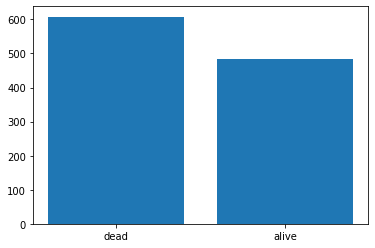

In [5]:
import matplotlib.pyplot as plt

plt.bar(x=['dead','alive'],height=[np.sum(labels==0),np.sum(labels==1)])

It can be seen that the labels are fairly balanced, so using accuracy as our metric in future models would make sense.

Next we plot the correlation matrix of each dataset to see how much their columns are correlated: 

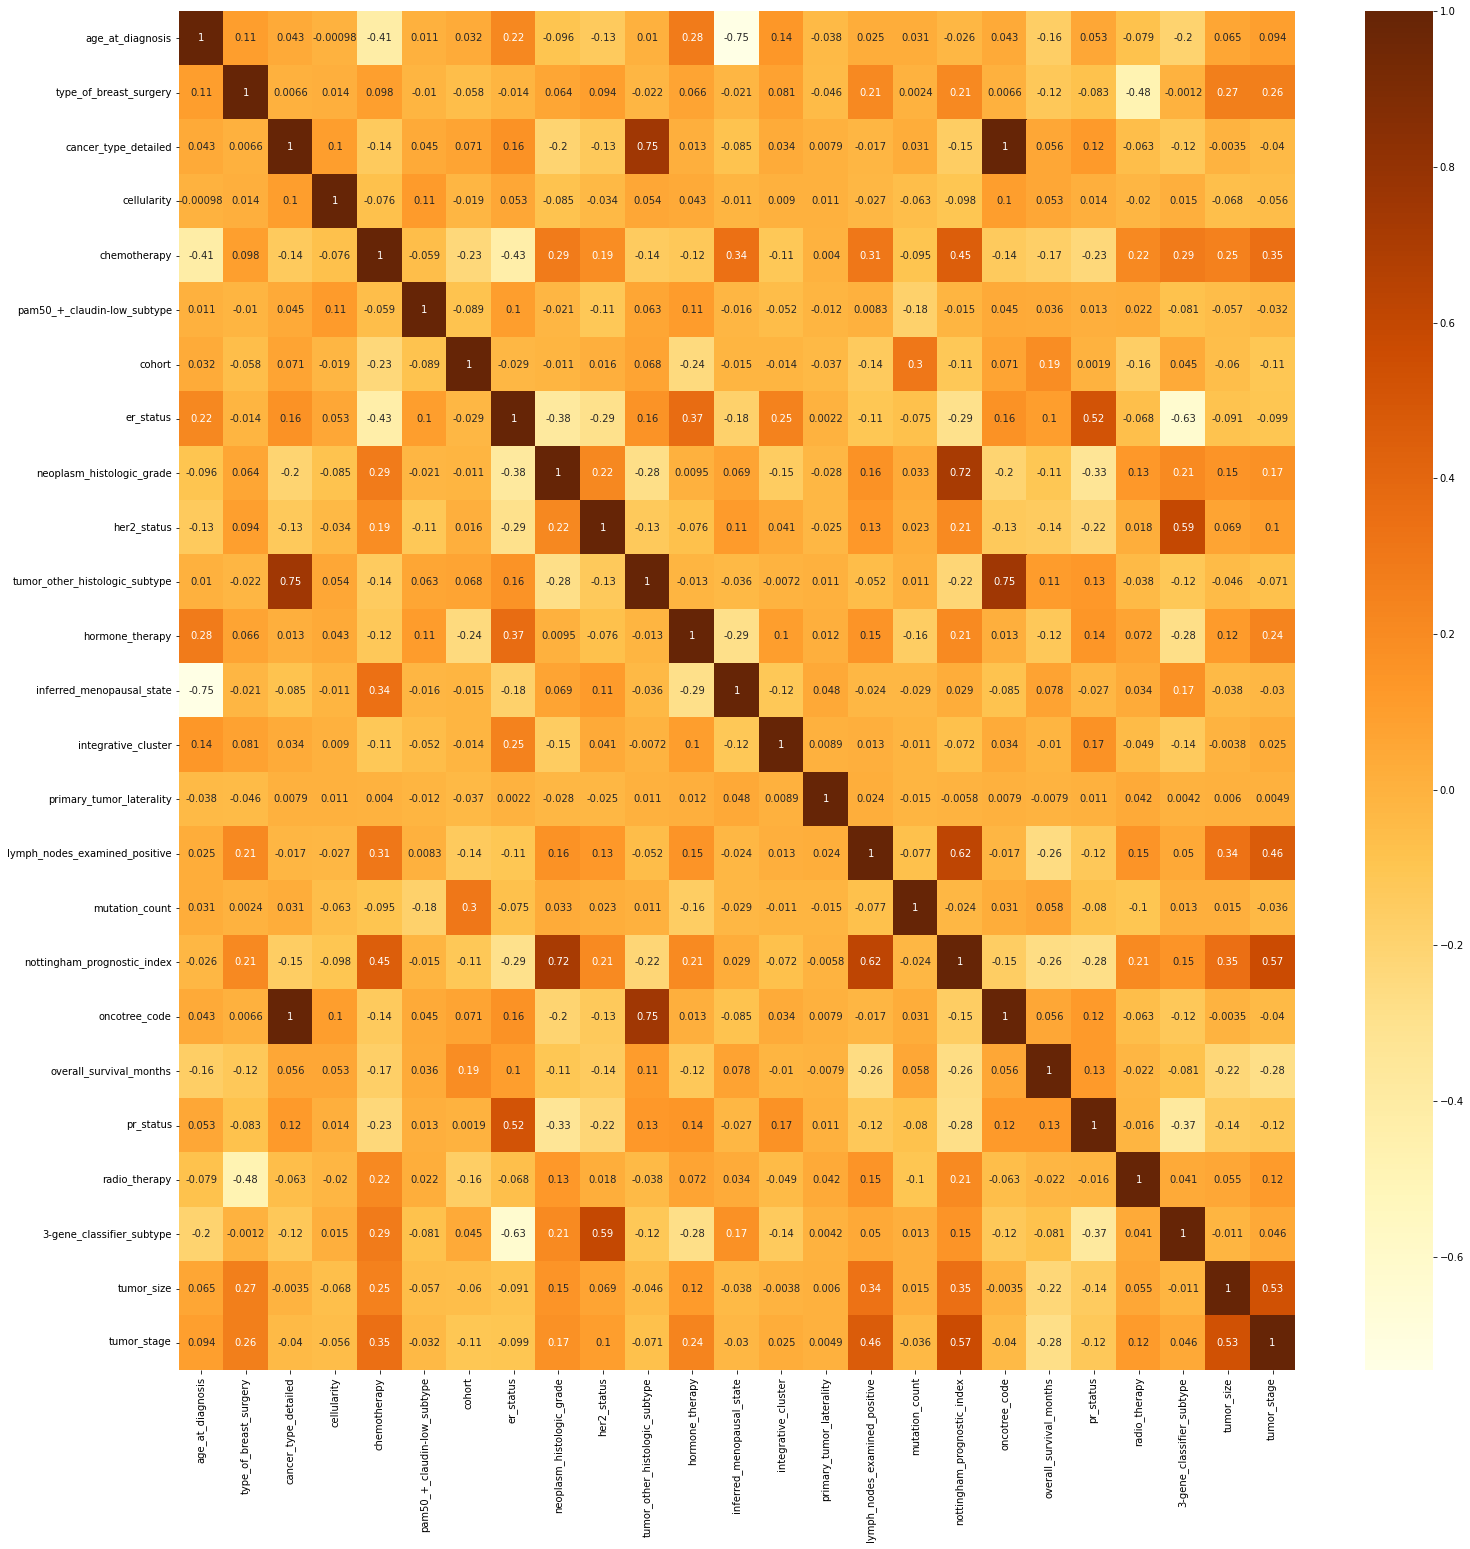

In [6]:
# for clinical dataset
import seaborn as sns
plt.figure(figsize=(25,25))
sns.heatmap(data = clinical_dataset.corr(), annot=True, cmap="YlOrBr")
plt.show()

It can be seen from the heatmap that we have some pairs of columns that are highly correlated (or even redundant). For examples, columns 'cancer_type_detailed' and 'oncotree_code' are exactly the same and we can remove one of them:

In [7]:
clinical_dataset.drop(columns=['oncotree_code'],inplace=True)
print(clinical_dataset.shape)

(1092, 24)


We perform the same analysis on gene expression dataset. Since the number of features of this dataset is large, we draw a continous image of the correlation matrix to get a general idea of how much the columns are correlated (darker means more correlation):

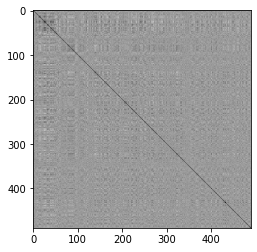

In [8]:
cor=expression_dataset.corr().to_numpy()
plt.imshow(1-cor,cmap='gray')
plt.show()

Finally, we normalize the columns of each dataset:

In [9]:

clinical_dataset=(clinical_dataset-clinical_dataset.mean())/clinical_dataset.std()
expression_dataset=(expression_dataset-expression_dataset.mean())/expression_dataset.std()

## Dimension Reduction (20 + Up to 10 Points Optional)

For each dataset, investigate whether it is needed to use a dimensionality reduction approach or not. If yes, please reduce the dataset's dimension. You can use UMAP for this purpose but any other approach is acceptable. Finding the most important features contains extra points.

For clinical data, since there is a relatively high correlation between its columns (according to the heatmap of correlation matrix) dimensionality reduction can help. 

For Gene expression dataset, there are some highly correlated columns as well. Besides this, number of features is relatively large and may cause overfitting, so again, it makes sense to reduce the dimension of data.

We begin by reducing the dimension of each dataset to 2 in order to visualize:

In [10]:
# installing and importing
!pip install umap-learn
import umap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=ba268d73dcc8a330403dd30559580eb64f9d961475f5519fcf1d25544b4a41cc
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=fceeb4dba058cd355d61d9c6802b6a9334c73b071cef39409e7a4515ce2a6d04
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


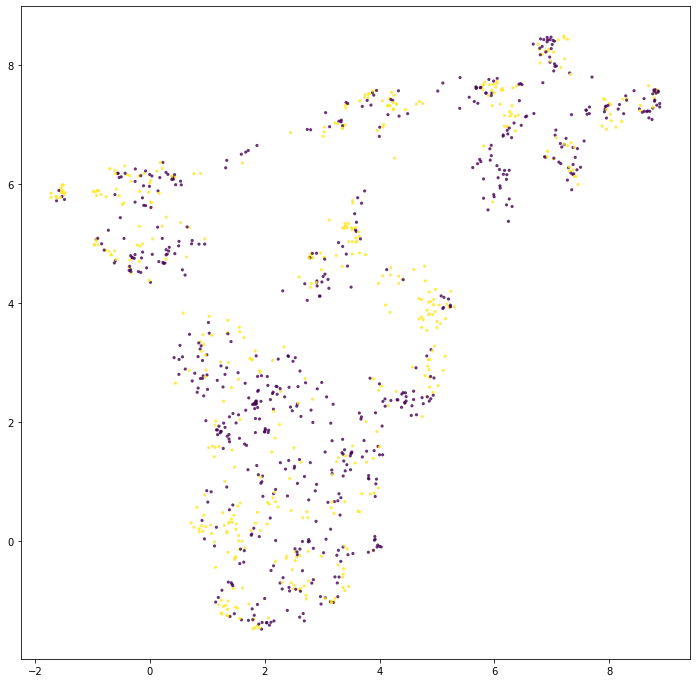

In [11]:
clinical_2d=umap.UMAP(n_components=2,metric='correlation').fit_transform(clinical_dataset)
plt.figure(figsize=(12,12))
plt.scatter(clinical_2d[:,0], clinical_2d[:,1], 
            c=labels,
            edgecolor='none', 
            alpha=0.80, 
            s=10)
plt.show()

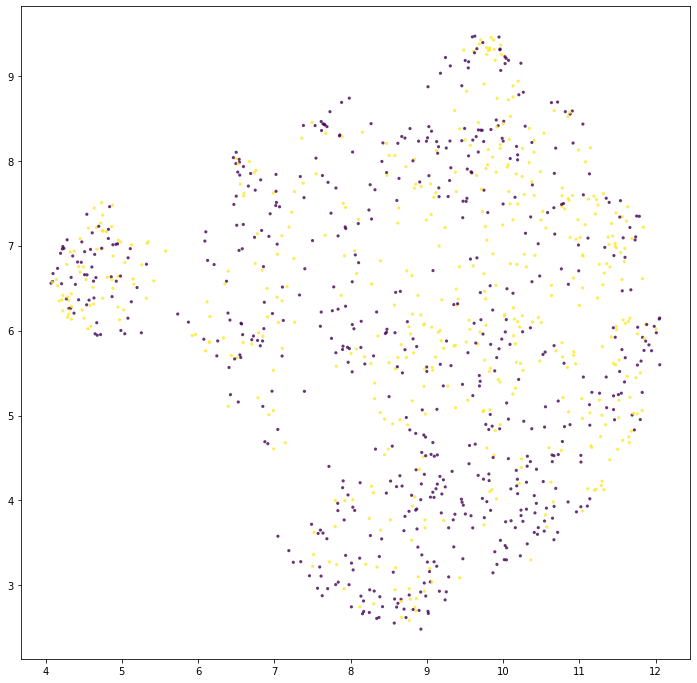

In [12]:
expression_2d=umap.UMAP(n_components=2,metric='correlation').fit_transform(expression_dataset)
plt.figure(figsize=(12,12))
plt.scatter(expression_2d[:,0], expression_2d[:,1], 
            c=labels,
            edgecolor='none', 
            alpha=0.80, 
            s=10)
plt.show()

Now we reduce the dimension of each dataset 

In [13]:
# dimensionality reduction with umap
clinical_umap=umap.UMAP(n_components=10,metric='correlation').fit_transform(clinical_dataset)
expression_umap=umap.UMAP(n_components=100,metric='correlation').fit_transform(expression_dataset)


Along with UMAP, dimensionality reduction with Autoencoders is also done:

In [14]:
import keras
from keras.layers import Dense


class DenseAutoEncoder:

    def __init__(self, input_size, encoding_dims=[2], encoding_activations=['relu'], decoding_dims=[2],
                 decoding_activations=['sigmoid']):
        self.input_size = input_size
        self.input_data = keras.Input(shape=(input_size,))
        self.encoded, self.encoder = self.create_encoder(encoding_dims, encoding_activations)
        self.decoded, self.decoder = self.create_decoder(decoding_dims, decoding_activations)
        self.auto_encoder = keras.Model(self.input_data, self.decoded)

    def create_encoder(self, encoding_dims, encoding_activations):
        encoded = self.input_data
        for i in range(len(encoding_dims)):
            dim = encoding_dims[i]
            activation = encoding_activations[i]
            encoded = Dense(dim, activation)(encoded)
        encoder = keras.Model(self.input_data, encoded)
        return encoded, encoder

    def create_decoder(self, decoding_dims, decoding_activations):
        decoded = self.encoded
        for i in range(1, len(decoding_dims)):
            dim = decoding_dims[i]
            activation = decoding_activations[i]
            decoded = Dense(dim, activation)(decoded)
        decoded = Dense(self.input_size, decoding_activations[-1])(decoded)
        decoder = keras.Model(self.encoded, decoded)
        return decoded, decoder

    def train(self, X,optimizer='adam',loss='binary_crossentropy', batch_size=256, epochs=50):
        self.auto_encoder.compile(optimizer=optimizer,loss=loss)
        self.auto_encoder.fit(X, X, batch_size, epochs,verbose=False)

    def predict(self, X):
        return self.auto_encoder.predict(X)

    def encode(self,X):
        return self.encoder.predict(X)



In [15]:
clinic_encoder=DenseAutoEncoder(clinical_dataset.shape[1],[32,32,8],['relu','relu','relu'],[2,32,32],
                                ['relu','relu','relu'])
clinic_encoder.train(clinical_dataset)
clinical_ae=clinic_encoder.encode(clinical_dataset)

expression_encoder=DenseAutoEncoder(expression_dataset.shape[1],[256,128,64],['relu','relu','relu'],[64,128,256],
                                ['relu','relu','relu'])
expression_encoder.train(expression_dataset,batch_size=64)
expression_ae=expression_encoder.encode(expression_dataset)

35/35 [==============================] - 0s 2ms/step


Finally, we put all our datasets in a dictionary in order to access them easily:

In [16]:
datasets={
    'Clinical dataset':clinical_dataset.to_numpy(),
    'Gene Expression dataset':expression_dataset.to_numpy(),
    'Reduced Clinical data with umap':clinical_umap,
    'Reduced Gene Expression data with umap':expression_umap,
    'Reduced Clinical data with AutoEncoder':clinical_ae,
     'Reduced Gene Expression data with AutoEncoder':expression_ae,
}


# Classic Model (25 Points)

In this section, you must implement a classic classification model for clinical, gene expressions, and reduced gene expressions datasets. Using Random Forest is suggested. (minimum acceptable accuracy = 60%)

We first add a function that takes a model and dataset as input, and trains the model on dataset and outputs the accuracy of model on test data:

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
def fit_classic_model(model,data,labels,test_ratio=0.2):
  x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = test_ratio, random_state = 42)
  model.fit(x_train,y_train)
  y_pred=model.predict(x_test)
  return accuracy_score(y_test,y_pred)*100


A random forest classifier and XGBoost classifier are fitted to each dataset:

In [18]:

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
XG_classifier = XGBClassifier(random_state = 42)
random_forest = RandomForestClassifier(n_estimators=700, max_leaf_nodes=16, n_jobs=-1)
xgboost_accs={}
rf_accs={}
for dataset_name in datasets.keys():
  dataset=datasets[dataset_name]
  rf_acc=fit_classic_model(random_forest,dataset,labels)
  xg_acc=fit_classic_model(XG_classifier,dataset,labels)
  print('Accuracy of Random forest on ',dataset_name,": ",rf_acc)
  rf_accs[dataset_name]=rf_acc
  print('Accuracy of XGBoost on ',dataset_name,": ",xg_acc)
  xgboost_accs[dataset_name]=xg_acc


Accuracy of Random forest on  Clinical dataset :  77.1689497716895
Accuracy of XGBoost on  Clinical dataset :  75.34246575342466
Accuracy of Random forest on  Gene Expression dataset :  64.38356164383562
Accuracy of XGBoost on  Gene Expression dataset :  66.66666666666666
Accuracy of Random forest on  Reduced Clinical data with umap :  65.75342465753424
Accuracy of XGBoost on  Reduced Clinical data with umap :  64.84018264840182
Accuracy of Random forest on  Reduced Gene Expression data with umap :  63.013698630136986
Accuracy of XGBoost on  Reduced Gene Expression data with umap :  57.99086757990868
Accuracy of Random forest on  Reduced Clinical data with AutoEncoder :  58.44748858447488
Accuracy of XGBoost on  Reduced Clinical data with AutoEncoder :  54.337899543378995
Accuracy of Random forest on  Reduced Gene Expression data with AutoEncoder :  58.9041095890411
Accuracy of XGBoost on  Reduced Gene Expression data with AutoEncoder :  53.88127853881278


# Neural Network (30 Points)

In this section, you must implement a neural network model for clinical, gene expressions and reduced gene expressions datasets. Using the MPL models is suggested. (minimum acceptable accuracy = 60%)

We first implement a class for creating and training MLPs:

In [19]:
import keras
from keras.layers import Input, Dense


class MLP:

    def __init__(self, input_size, neurons_per_layer=[256], activations=['relu']):
        self.input_size = input_size
        self.input_data = Input(shape=(input_size,))
        self.net = self.create_network(neurons_per_layer, activations)
        self.model = keras.Model(self.input_data, self.net)

    def create_network(self, neurons_per_layer, activations):
        net = self.input_data
        for i in range(len(neurons_per_layer)):
            n = neurons_per_layer[i]
            activation = activations[i]
            net = Dense(n, activation)(net)
        return net

    def train(self, X, y, optimizer='adam', loss='binary_crossentropy',validation_ratio=0.2, batch_size=128, epochs=50):
        self.model.compile(optimizer=optimizer, loss=loss,metrics=['accuracy'])
        history=self.model.fit(X, y, batch_size=batch_size, epochs=epochs,validation_split=validation_ratio,verbose=False)
        return history

    def predict(self, X,y=None):
        y_pred=self.model.predict(X)
        y_pred[y_pred>=0.5]=1
        y_pred[y_pred<0.5]=0
        y_pred=y_pred.astype(int)
        if y is not None:
          acc=accuracy_score(y,y_pred)
          return y_pred,acc
        else:
          return y_pred
        


We also add a function to do both training and test on given dataset:

In [36]:
def fit_network(net,data,labels,epochs=100,test_ratio=0.2,validation_ratio=0.2):
      x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = test_ratio, random_state = 42)
      history=net.train(x_train,y_train,validation_ratio=validation_ratio,epochs=epochs)
      train_loss,train_acc=history.history['loss'],history.history['accuracy']
      y_pred,test_acc=net.predict(x_test,y_test)
      return train_loss,train_acc,test_acc


For each dataset, we train three networks with different number of layers to see the impact of increasing the number of layers on accuracy:

In [37]:
net1_layers,net2_layers,net3_layers=[64,1],[64,128,64,1],[64,128,128,64,32,1]
net1_acts,net2_acts,net3_acts=['relu','sigmoid'],['relu','relu','relu','sigmoid'],['relu','relu','relu','relu','relu','sigmoid']

net_clinic1=MLP(clinical_dataset.shape[1],net1_layers,net1_acts)

losses={}
val_accs={}
network_accs={}
for dataset_name in datasets.keys():
  print("====> ",dataset_name,": ")
  dataset=datasets[dataset_name]
  net1=MLP(dataset.shape[1],net1_layers,net1_acts)
  net2=MLP(dataset.shape[1],net2_layers,net2_acts)
  net3=MLP(dataset.shape[1],net3_layers,net3_acts)
  train_loss,train_acc,test_acc=fit_network(net1,dataset,labels)
  print('Accuracy of Net1: ',test_acc)
  losses['Net1 on '+dataset_name]=train_loss
  val_accs['Net1 on '+dataset_name]=train_acc
  network_accs['Net1 on '+dataset_name]=test_acc

  train_loss,train_acc,test_acc=fit_network(net2,dataset,labels)
  print('Accuracy of Net2: ',test_acc)
  losses['Net2 on '+dataset_name]=train_loss
  val_accs['Net2 on '+dataset_name]=train_acc
  network_accs['Net2 on '+dataset_name]=test_acc

  train_loss,train_acc,test_acc=fit_network(net3,dataset,labels)
  print('Accuracy of Net3: ',test_acc)
  losses['Net3 on '+dataset_name]=train_loss
  val_accs['Net3 on '+dataset_name]=train_acc
  network_accs['Net3 on '+dataset_name]=test_acc




====>  Clinical dataset : 
7/7 [==============================] - 0s 2ms/step
Accuracy of Net1:  0.7671232876712328
7/7 [==============================] - 0s 5ms/step
Accuracy of Net2:  0.7214611872146118
7/7 [==============================] - 0s 3ms/step
Accuracy of Net3:  0.6940639269406392
====>  Gene Expression dataset : 
7/7 [==============================] - 0s 3ms/step
Accuracy of Net1:  0.6301369863013698
7/7 [==============================] - 0s 4ms/step
Accuracy of Net2:  0.5981735159817352
7/7 [==============================] - 0s 3ms/step
Accuracy of Net3:  0.5753424657534246
====>  Reduced Clinical data with umap : 
7/7 [==============================] - 0s 2ms/step
Accuracy of Net1:  0.6164383561643836
7/7 [==============================] - 0s 2ms/step
Accuracy of Net2:  0.639269406392694
7/7 [==============================] - 0s 3ms/step
Accuracy of Net3:  0.6529680365296804
====>  Reduced Gene Expression data with umap : 
7/7 [==============================] - 0s 2ms/st

Plot of losses of each model on each dataset:

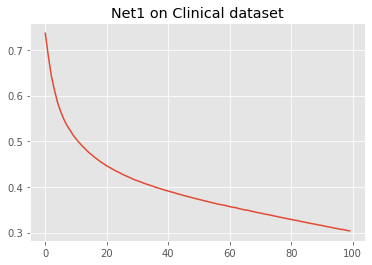

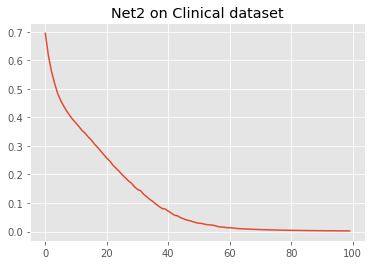

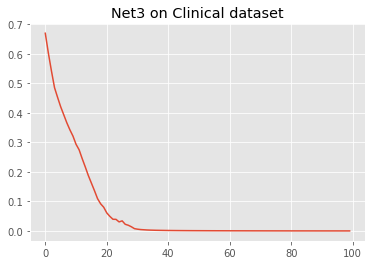

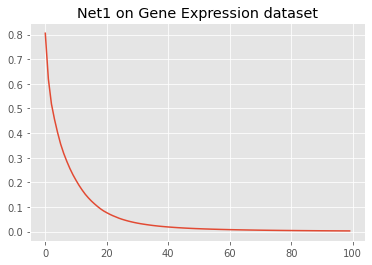

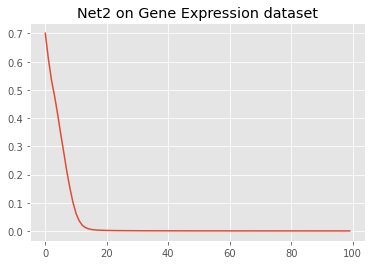

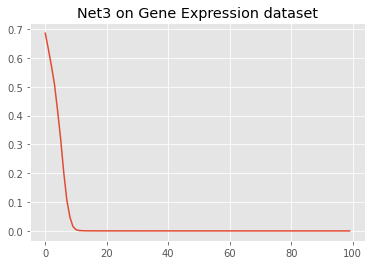

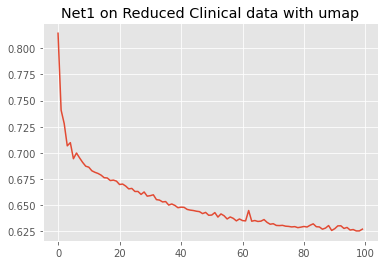

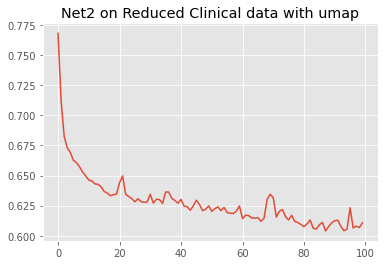

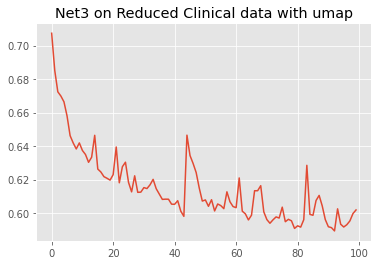

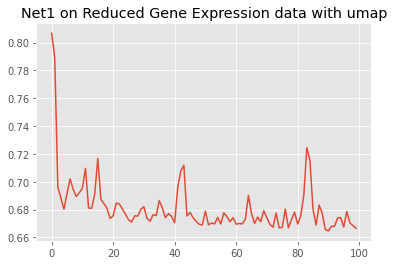

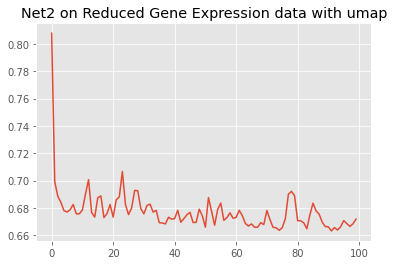

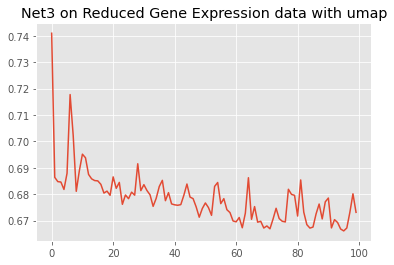

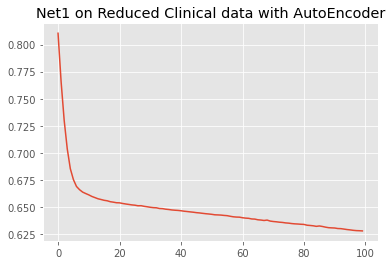

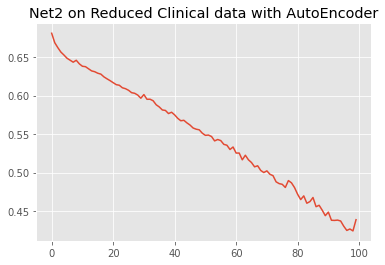

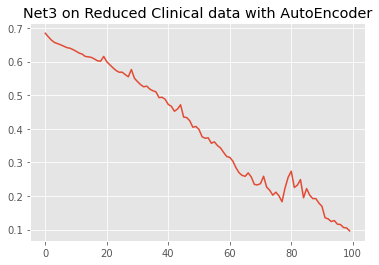

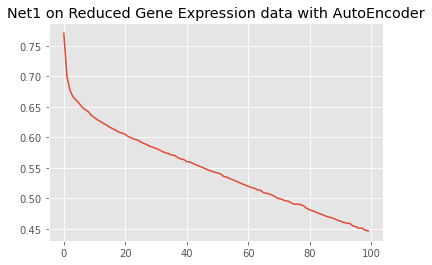

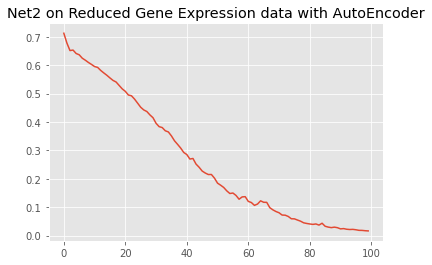

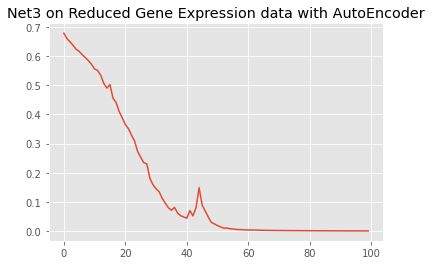

In [38]:
plt.style.use('ggplot')

for key in losses.keys():
  loss=losses[key]
  plt.title(key)
  plt.plot(loss)
  plt.show()

# Model Comparison (10 Points)

Compare different models and different datasets (clinical, gene expressions, and gene reduced expressions) and try to explain their differences.

Let us draw some histograms to better see the difference of accuracy of each model on each dataset:

Maximum accuracy is reached by  Random Forest  with accuracy  77.1689497716895


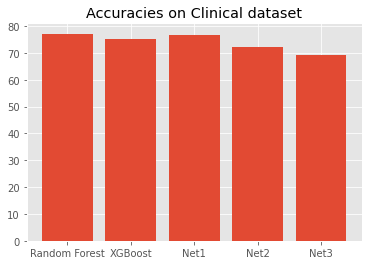

Maximum accuracy is reached by  XGBoost  with accuracy  66.66666666666666


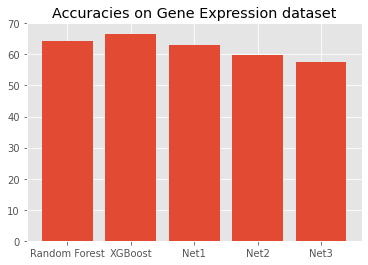

Maximum accuracy is reached by  Random Forest  with accuracy  65.75342465753424


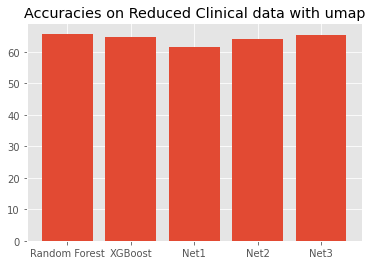

Maximum accuracy is reached by  Random Forest  with accuracy  63.013698630136986


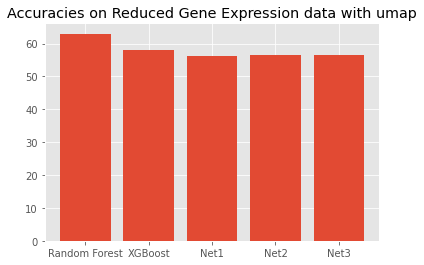

Maximum accuracy is reached by  Net1  with accuracy  59.3607305936073


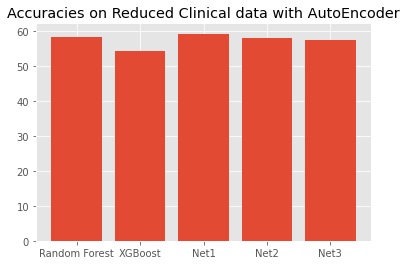

Maximum accuracy is reached by  Random Forest  with accuracy  58.9041095890411


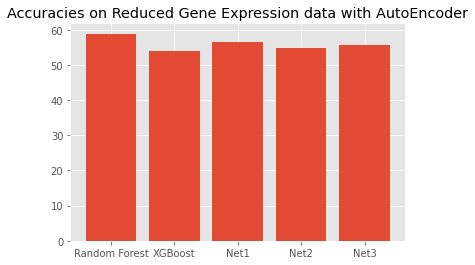

In [39]:
x=['Random Forest','XGBoost','Net1','Net2','Net3']
for dataset_name in datasets.keys():
  accs=[rf_accs[dataset_name],xgboost_accs[dataset_name],network_accs['Net1 on '+dataset_name]*100,network_accs['Net2 on '+dataset_name]*100,network_accs['Net3 on '+dataset_name]*100]
  max_acc=max(accs)
  print('Maximum accuracy is reached by ',x[accs.index(max_acc)],' with accuracy ',max_acc)
  plt.title('Accuracies on '+dataset_name)
  plt.bar(x=x,height=accs)
  plt.show()

As we can see from the histograms, it looks like that the classical models have better performance on both datasets, except for reduced clinical dataset with autoencoder (on which net1 performs better, with a small difference in accuracy compared to others) 

Notice that dimensionality reduction doesn't cause the models to perform better. Also, overall accuracy of models on each dataset is pretty low. Reason for this is most probably the datasets themselves. It can be seen from the visualization of each dataset in previous parts that data points are not really seperatable, which means that features of each dataset have low information for predicting the label of each sample. Hence, the best way to have a better classifier is to add some features with more correlation with the labels.